In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
Data=pd.read_csv('/kaggle/input/prodataset/AI_Resume_Screening.csv')

In [2]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score (0-100)        1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [9]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

In [13]:
data = pd.read_csv('/kaggle/input/prodataset/AI_Resume_Screening.csv') 
print("✅ Dataset loaded. Total rows:", len(data))


data = data.dropna(subset=['Resume_ID']).reset_index(drop=True)


✅ Dataset loaded. Total rows: 1000


In [19]:
import string

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = ' '.join(text.split())  
    return text

data['Cleaned_Resume_ID'] = data['Resume_ID'].apply(clean_text)

In [21]:
job_description = """
Looking for a candidate with strong Python, data analysis, machine learning, SQL,
data visualization, and problem-solving skills.
"""

cleaned_jd = clean_text(job_description)


In [23]:
all_texts = data['Cleaned_Resume_ID'].tolist()
all_texts.append(cleaned_jd)  # Add job description at the end

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

print("✅ TF-IDF vectorization completed.")

✅ TF-IDF vectorization completed.


In [25]:
similarities = cosine_similarity(tfidf_matrix[:-1], tfidf_matrix[-1:])


data['Match_Score'] = similarities.flatten()


In [26]:
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)
print("\n📊 Top 5 Matching Resumes:\n")
for i in range(5):
    print(f"Rank {i+1} - Match Score: {round(ranked.loc[i, 'Match_Score'], 4)}")



📊 Top 5 Matching Resumes:

Rank 1 - Match Score: 0.0
Rank 2 - Match Score: 0.0
Rank 3 - Match Score: 0.0
Rank 4 - Match Score: 0.0
Rank 5 - Match Score: 0.0


In [28]:
ranked[['Resume_ID', 'Match_Score']].to_csv("ranked_resumes.csv", index=False)
print("📁 Ranked results saved to 'ranked_resumes.csv'.")


📁 Ranked results saved to 'ranked_resumes.csv'.


In [32]:
keywords = list(set(cleaned_jd.split()))  

def highlight_keywords(text, keywords):
    words = text.split()
    result = []
    for word in words:
        if word in keywords:
            result.append(f"*{word.upper()}*")
        else:
            result.append(word)
    return ' '.join(result)

highlighted = highlight_keywords(ranked.loc[0, 'Cleaned_Resume_ID'], keywords)
print("\n🔍 Highlighted Resume Preview (Top Match):\n")
print(highlighted[:1000]) 



🔍 Highlighted Resume Preview (Top Match):

1


In [36]:
import os

if not os.path.exists("Top_Resumes"):
    os.makedirs("Top_Resumes")

for i in range(5):  # Top 5 resumes
    resume_text = ranked.loc[i, 'Resume_ID']
    with open(f"Top_Resumes/Rank_{i+1}_Resume.txt", 'w', encoding='utf-8') as f:
        f.write(str(resume_text))  # Convert to string

print("📂 Top 5 resumes exported to 'Top_Resumes/' folder.")

📂 Top 5 resumes exported to 'Top_Resumes/' folder.


In [ ]:
# ----------------- ADD-ON FEATURE 1: Define JD Skills -----------------
jd_keywords = cleaned_jd.split()
jd_keywords = list(set(jd_keywords))  # Unique skill keywords from job description

# ----------------- ADD-ON FEATURE 2: Count Matching Skills -----------------
def count_matched_skills(resume_text, keywords):
    resume_words = set(resume_text.split())
    matched = [word for word in resume_words if word in keywords]
    return len(matched), ', '.join(matched)

match_counts = []
matched_skills_text = []

for resume in data['Cleaned_Resume_ID']:
    count, matched_str = count_matched_skills(resume, jd_keywords)
    match_counts.append(count)
    matched_skills_text.append(matched_str)

# Add new columns to DataFrame
data['Skill_Match_Count'] = match_counts
data['Matched_Skills'] = matched_skills_text

# Update ranked dataset (again)
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)

# ----------------- ADD-ON FEATURE 3: Show Skill Match Report -----------------
print("\n📋 Skill Match Summary (Top 5 Resumes):\n")
for i in range(5):
    print(f"Rank {i+1}")
    print("Match Score:", round(ranked.loc[i, 'Match_Score'], 4))
    print("Matched Skills:", ranked.loc[i, 'Matched_Skills'])
    print("Total Skills Matched:", ranked.loc[i, 'Skill_Match_Count'])
    print("-" * 60)

# ----------------- ADD-ON FEATURE 4: Save Enhanced Report -----------------
ranked[['Resume_ID', 'Match_Score', 'Skill_Match_Count', 'Matched_Skills']].to_csv(
    "enhanced_resume_match_report.csv", index=False
)
print("📁 Enhanced report saved to 'enhanced_resume_match_report.csv'.")

# ----------------- ADD-ON FEATURE 5: Show Ranking Chart -----------------
import matplotlib.pyplot as plt

top_n = 5
top_scores = ranked.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_scores.index + 1, top_scores['Match_Score'], color='skyblue')
plt.xlabel("Match Score")
plt.ylabel("Resume Rank")
plt.title("Top Resume Match Scores")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
jd_keywords = cleaned_jd.split()
jd_keywords = list(set(jd_keywords))

In [39]:
def count_matched_skills(resume_text, keywords):
    resume_words = set(resume_text.split())
    matched = [word for word in resume_words if word in keywords]
    return len(matched), ', '.join(matched)

match_counts = []
matched_skills_text = []

for resume in data['Cleaned_Resume_ID']:
    count, matched_str = count_matched_skills(resume, jd_keywords)
    match_counts.append(count)
    matched_skills_text.append(matched_str)

# Add new columns to DataFrame
data['Skill_Match_Count'] = match_counts
data['Matched_Skills'] = matched_skills_text

# Update ranked dataset (again)
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)


In [40]:
print("\n📋 Skill Match Summary (Top 5 Resumes):\n")
for i in range(5):
    print(f"Rank {i+1}")
    print("Match Score:", round(ranked.loc[i, 'Match_Score'], 4))
    print("Matched Skills:", ranked.loc[i, 'Matched_Skills'])
    print("Total Skills Matched:", ranked.loc[i, 'Skill_Match_Count'])
    print("-" * 60)


📋 Skill Match Summary (Top 5 Resumes):

Rank 1
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 2
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 3
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 4
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 5
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------


In [41]:
ranked[['Resume_ID', 'Match_Score', 'Skill_Match_Count', 'Matched_Skills']].to_csv(
    "enhanced_resume_match_report.csv", index=False
)
print("📁 Enhanced report saved to 'enhanced_resume_match_report.csv'.")

📁 Enhanced report saved to 'enhanced_resume_match_report.csv'.


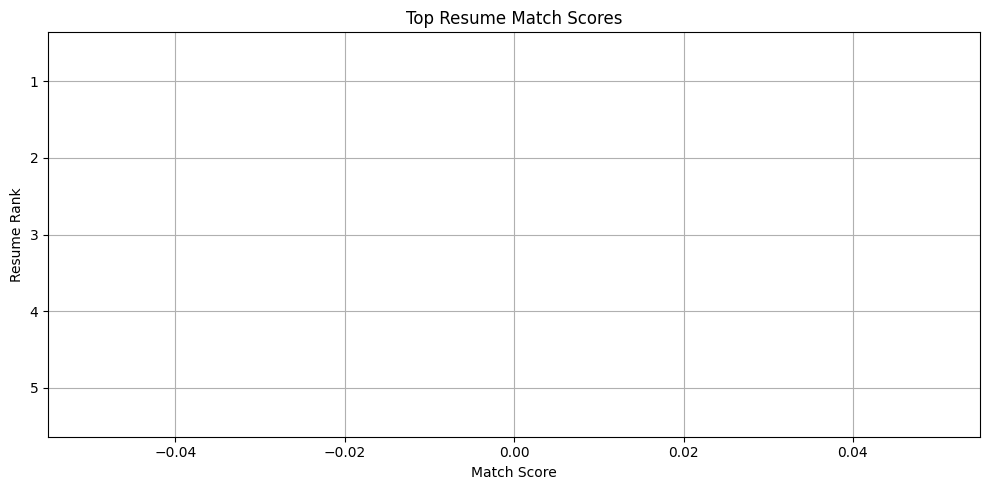

In [42]:
import matplotlib.pyplot as plt

top_n = 5
top_scores = ranked.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_scores.index + 1, top_scores['Match_Score'], color='skyblue')
plt.xlabel("Match Score")
plt.ylabel("Resume Rank")
plt.title("Top Resume Match Scores")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Dataset loaded. Total rows: 1000

🔍 Common keywords between resumes and job description:
⚠️ No overlap found! Match scores may be 0.
✅ Overlap count: 0

📊 Top 5 Matching Resumes:

Rank 1
Match Score: 0.0
Skills Matched: 
Total Skills: 0
--------------------------------------------------
Rank 2
Match Score: 0.0
Skills Matched: 
Total Skills: 0
--------------------------------------------------
Rank 3
Match Score: 0.0
Skills Matched: 
Total Skills: 0
--------------------------------------------------
Rank 4
Match Score: 0.0
Skills Matched: 
Total Skills: 0
--------------------------------------------------
Rank 5
Match Score: 0.0
Skills Matched: 
Total Skills: 0
--------------------------------------------------
📁 Saved: enhanced_resume_match_report.csv
📂 Top 5 resumes exported to 'Top_Resumes/' folder.


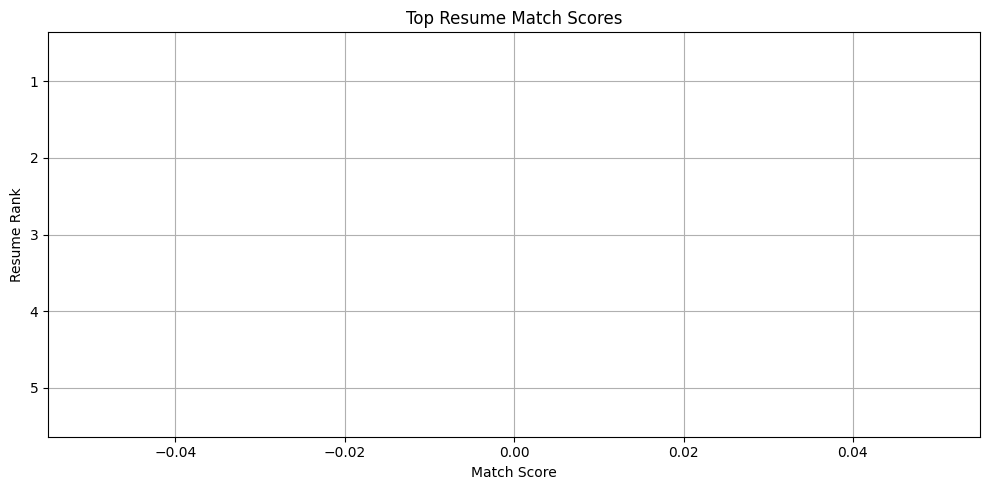

In [46]:
# ----------------- STEP 1: IMPORT LIBRARIES -----------------
import pandas as pd
import numpy as np
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os

# ----------------- STEP 2: LOAD DATA -----------------
data = pd.read_csv("/kaggle/input/prodataset/AI_Resume_Screening.csv")
print("✅ Dataset loaded. Total rows:", len(data))

# Drop rows with empty resume content
data = data.dropna(subset=['Resume_ID']).reset_index(drop=True)

# ----------------- STEP 3: CLEANING FUNCTION (ENHANCED) -----------------
import string

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = ' '.join(text.split())  
    return text

data['Cleaned_Resume_ID'] = data['Resume_ID'].apply(clean_text)
# ----------------- STEP 4: JOB DESCRIPTION -----------------
job_description = """
Looking for a data analyst or data scientist with skills in Python, machine learning, 
SQL, data visualization, pandas, numpy, and communication.
"""

cleaned_jd = clean_text(job_description)

# ----------------- STEP 5: DEBUG VOCABULARY OVERLAP -----------------
resume_vocab = set(" ".join(data['Cleaned_Resume_ID']).split())
jd_vocab = set(cleaned_jd.split())
common_words = resume_vocab.intersection(jd_vocab)

print("\n🔍 Common keywords between resumes and job description:")
print(common_words if common_words else "⚠️ No overlap found! Match scores may be 0.")
print(f"✅ Overlap count: {len(common_words)}\n")

# ----------------- STEP 6: TF-IDF VECTORIZATION -----------------
all_texts = data['Cleaned_Resume_ID'].tolist() + [cleaned_jd]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# ----------------- STEP 7: CALCULATE COSINE SIMILARITY -----------------
similarities = cosine_similarity(tfidf_matrix[:-1], tfidf_matrix[-1:])
data['Match_Score'] = similarities.flatten()

# ----------------- STEP 8: RANK RESUMES -----------------
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)

# ----------------- STEP 9: SKILL MATCHING -----------------
jd_keywords = list(set(cleaned_jd.split()))

def count_matched_skills(text, keywords):
    words = set(text.split())
    matched = [word for word in words if word in keywords]
    return len(matched), ', '.join(matched)

match_counts = []
matched_keywords = []

for resume_text in data['Cleaned_Resume_ID']:
    count, matches = count_matched_skills(resume_text, jd_keywords)
    match_counts.append(count)
    matched_keywords.append(matches)

data['Skill_Match_Count'] = match_counts
data['Matched_Skills'] = matched_keywords

# Update ranked dataset with skill info
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)

# ----------------- STEP 10: PRINT TOP 5 MATCHES -----------------
print("📊 Top 5 Matching Resumes:\n")
for i in range(5):
    print(f"Rank {i+1}")
    print("Match Score:", round(ranked.loc[i, 'Match_Score'], 4))
    print("Skills Matched:", ranked.loc[i, 'Matched_Skills'])
    print("Total Skills:", ranked.loc[i, 'Skill_Match_Count'])
    print("-" * 50)

# ----------------- STEP 11: EXPORT ENHANCED REPORT -----------------
ranked[['Resume_ID', 'Match_Score', 'Skill_Match_Count', 'Matched_Skills']].to_csv(
    "enhanced_resume_match_report.csv", index=False
)
print("📁 Saved: enhanced_resume_match_report.csv")

# ----------------- STEP 12: EXPORT TOP RESUMES AS FILES -----------------
import os

if not os.path.exists("Top_Resumes"):
    os.makedirs("Top_Resumes")

for i in range(5):  # Top 5 resumes
    resume_text = ranked.loc[i, 'Resume_ID']
    with open(f"Top_Resumes/Rank_{i+1}_Resume.txt", 'w', encoding='utf-8') as f:
        f.write(str(resume_text))  # Convert to string

print("📂 Top 5 resumes exported to 'Top_Resumes/' folder.")

# ----------------- STEP 13: BAR CHART OF TOP SCORES -----------------
top_n = 5
top_scores = ranked.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_scores.index + 1, top_scores['Match_Score'], color='skyblue')
plt.xlabel("Match Score")
plt.ylabel("Resume Rank")
plt.title("Top Resume Match Scores")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # keep alphanumeric + space
    text = ' '.join(text.split())
    return text

In [50]:
import string
import pandas as pd

# Assume clean_text and data are already defined

# Ensure Cleaned_Resume_ID is string and NaN safe
data['Cleaned_Resume_ID'] = data['Resume_ID'].astype(str).apply(clean_text)
cleaned_jd = clean_text(job_description)

# Safely join all cleaned resumes into one string
all_resume_text = " ".join(data['Cleaned_Resume_ID'].dropna().astype(str))

resume_words = set(all_resume_text.split())
jd_words = set(cleaned_jd.split())
common_words = resume_words.intersection(jd_words)

print("🔍 Common words between resumes and JD:", common_words)
if len(common_words) == 0:
    print("⚠️ No overlap in vocabulary. Match score will be 0.")
else:
    print(f"✅ Overlap found. {len(common_words)} common keywords.")

🔍 Common words between resumes and JD: set()
⚠️ No overlap in vocabulary. Match score will be 0.


In [51]:
from sklearn.feature_extraction.text import CountVectorizer  # alternative

vectorizer = TfidfVectorizer()  # or CountVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['Cleaned_Resume_ID'].tolist() + [cleaned_jd])


In [58]:
print("\n📋 Skill Match Summary (Top 5 Resumes):\n")
for i in range(5):
    print(f"Rank {i+1}")
    print("Match Score:", round(ranked.loc[i, 'Match_Score'], 4))
    print("Matched Skills:", ranked.loc[i, 'Matched_Skills'])
    print("Total Skills Matched:", ranked.loc[i, 'Skill_Match_Count'])
    print("-" * 60)
    


📋 Skill Match Summary (Top 5 Resumes):

Rank 1
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 2
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 3
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 4
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------
Rank 5
Match Score: 0.0
Matched Skills: 
Total Skills Matched: 0
------------------------------------------------------------


In [53]:
import os

if not os.path.exists("Top_Resumes"):
    os.makedirs("Top_Resumes")

for i in range(5):  # Top 5 resumes
    resume_text = ranked.loc[i, 'Resume_ID']
    with open(f"Top_Resumes/Rank_{i+1}_Resume.txt", 'w', encoding='utf-8') as f:
        f.write(str(resume_text))  # Convert to string

print("📂 Top 5 resumes exported to 'Top_Resumes/' folder.")

📂 Top 5 resumes exported to 'Top_Resumes/' folder.


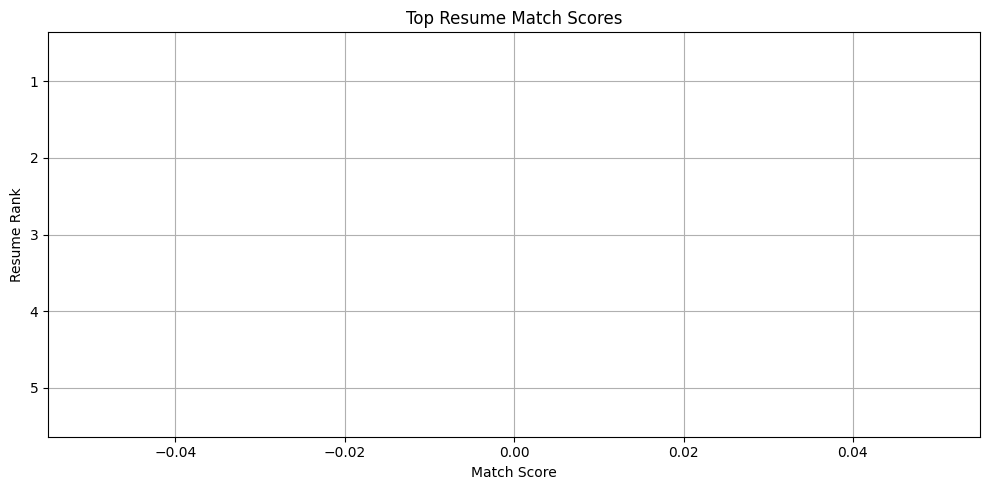

In [60]:
top_n = 5
top_scores = ranked.head(top_n)

plt.figure(figsize=(10, 5))
plt.barh(top_scores.index + 1, top_scores['Match_Score'], color='skyblue')
plt.xlabel("Match Score")
plt.ylabel("Resume Rank")
plt.title("Top Resume Match Scores")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

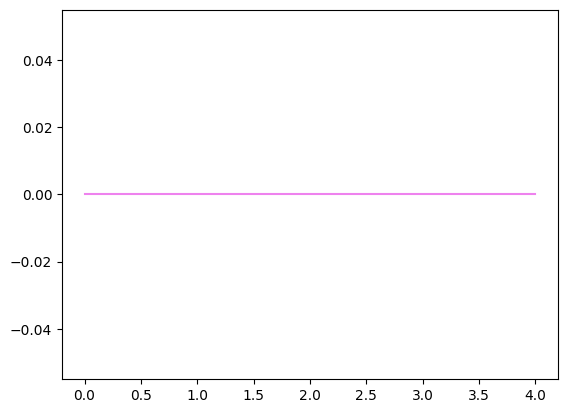

In [61]:
plt.plot(top_scores['Match_Score'],color='violet')

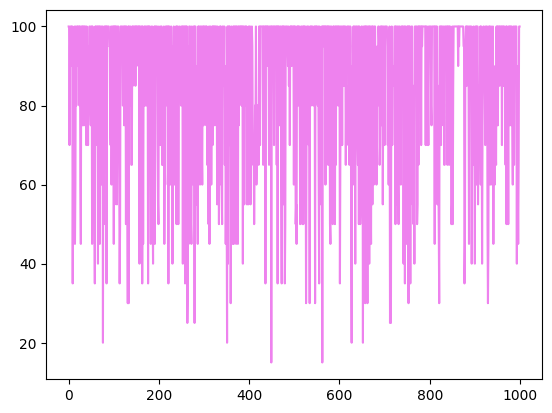

In [65]:
plt.plot(Data['AI Score (0-100)'],color='violet')

In [3]:
import os
import pandas as pd
import string
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Clean text function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# 2. Example: Load your data
# data = pd.read_csv('your_resume_data.csv')  # Uncomment and adapt if needed
data = pd.read_csv("/kaggle/input/prodataset/AI_Resume_Screening.csv") 
job_description = open('job_description.txt').read()  # Uncomment and adapt if needed

# 3. Clean the resumes and job description
data['Cleaned_Resume'] = data['Resume_ID'].astype(str).apply(clean_text)
cleaned_jd = clean_text(job_description)

# 4. Load a pre-trained sentence transformer model (downloads automatically)
model = SentenceTransformer('all-MiniLM-L6-v2')

# 5. Compute embeddings
resume_embeddings = model.encode(data['Cleaned_Resume'].tolist(), convert_to_tensor=False)
jd_embedding = model.encode([cleaned_jd], convert_to_tensor=False)

# 6. Compute cosine similarities
from numpy import dot
from numpy.linalg import norm
def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

similarities = [cos_sim(res_emb, jd_embedding[0]) for res_emb in resume_embeddings]

# 7. Add scores and rank
data['Match_Score'] = similarities
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)

# 8. Export Top 5 resumes
os.makedirs("Top_Resumes", exist_ok=True)
for i in range(min(5, len(ranked))):
    resume_text = ranked.loc[i, 'Resume_ID']
    with open(f"Top_Resumes/Rank_{i+1}_Resume.txt", 'w', encoding='utf-8') as f:
        f.write(str(resume_text))

print("📂 Top 5 resumes exported to 'Top_Resumes/' folder.")
print(ranked[['Resume_ID', 'Match_Score']].head(5))

FileNotFoundError: [Errno 2] No such file or directory: 'job_description.txt'

In [4]:
import os
import pandas as pd
import string
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Use your actual file path for your resume dataset
data = pd.read_csv("/kaggle/input/prodataset/AI_Resume_Screening.csv")

# Fix: Provide job description directly as a string
job_description = """
Data Scientist needed with strong Python, machine learning, and NLP skills.
Experience with resume screening is a plus.
"""

data['Cleaned_Resume'] = data['Resume_ID'].astype(str).apply(clean_text)
cleaned_jd = clean_text(job_description)

model = SentenceTransformer('all-MiniLM-L6-v2')

resume_embeddings = model.encode(data['Cleaned_Resume'].tolist(), convert_to_tensor=False)
jd_embedding = model.encode([cleaned_jd], convert_to_tensor=False)

from numpy import dot
from numpy.linalg import norm
def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

similarities = [cos_sim(res_emb, jd_embedding[0]) for res_emb in resume_embeddings]

data['Match_Score'] = similarities
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)

os.makedirs("Top_Resumes", exist_ok=True)
for i in range(min(5, len(ranked))):
    resume_text = ranked.loc[i, 'Resume_ID']
    with open(f"Top_Resumes/Rank_{i+1}_Resume.txt", 'w', encoding='utf-8') as f:
        f.write(str(resume_text))

print("📂 Top 5 resumes exported to 'Top_Resumes/' folder.")
print(ranked[['Resume_ID', 'Match_Score']].head(5))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📂 Top 5 resumes exported to 'Top_Resumes/' folder.
   Resume_ID  Match_Score
0        451     0.096790
1        999     0.085740
2        911     0.085652
3        529     0.079023
4        259     0.077449


In [10]:
import pandas as pd
import string
from sentence_transformers import SentenceTransformer
from numpy import dot
from numpy.linalg import norm

# Helper functions
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

# Load your data (update the path below if your dataset folder is different)
data = pd.read_csv('/kaggle/input/prodataset/AI_Resume_Screening.csv')

# Paste your job description here
job_description = """
Data Scientist needed with strong Python, machine learning, and NLP skills.
Experience with resume screening is a plus.
"""

# Clean text
data['Cleaned_Resume'] = data['Resume_ID'].astype(str).apply(clean_text)
cleaned_jd = clean_text(job_description)

# Load transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeddings = model.encode(data['Cleaned_Resume'].tolist(), convert_to_tensor=False)
jd_embedding = model.encode([cleaned_jd], convert_to_tensor=False)

# Calculate similarities
similarities = [cos_sim(res_emb, jd_embedding[0]) for res_emb in resume_embeddings]
data['Match_Score'] = similarities

# Rank and show top 5
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)
print("Top 5 Ranked Resumes:")
print(ranked[['Resume_ID', 'Match_Score']].head(5))

# Export results for download
ranked.to_csv('ranked_resumes.csv', index=False)
print("Full ranking saved to ranked_resumes.csv")

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 Ranked Resumes:
   Resume_ID  Match_Score
0        451     0.096790
1        999     0.085740
2        911     0.085652
3        529     0.079023
4        259     0.077449
Full ranking saved to ranked_resumes.csv
